# DRW Results (Figure 5) used in the manuscript:
### Song, Z., & Jiang, Z. (2023). A Novel Data-driven Numerical Method for Hydrological Modeling of Water Infiltration in Porous Media. arXiv preprint arXiv:2310.02806
## DRW is the genealization of GRW solver originally presented in:
### Suciu, N., Illiano, D., Prechtel, A., Radu, F. A., 2021. https://github.com/PMFlow/RichardsEquation Git repository https://doi.org/10.5281/zenodo.4709693
### Suciu, N., Illiano, D., Prechtel, A.,  Radu, F. A., 2021. Global random walk solvers for fully coupled flow and transport in saturated/unsaturated porous media. Advances in Water Resources, 152, 103935
## DRW naturally incorporates the encoder-decoder architecture, achieving message passing via GRW-like schemes. For details, please refer to:
### Song, Z., & Jiang, Z. (2023). A Novel Data-driven Numerical Method for Hydrological Modeling of Water Infiltration in Porous Media. arXiv preprint arXiv:2310.02806

Training time: 61.850138664245605
Total execution time: 91.6156358718872
Coefficient matrix: [[-9.99954441e-01 -2.27795503e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.27795503e-05 -9.99954441e-01 -2.27795637e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.27795503e-05 -9.99954441e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.96024346e-01
  -1.99554976e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.98010375e-03
  -9.95994328e-01 -2.01012245e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.99554976e-03 -9.95979755e-01]]
Spetral raduis: 0.9999999293065356
Condition number: 1.0077058572941655


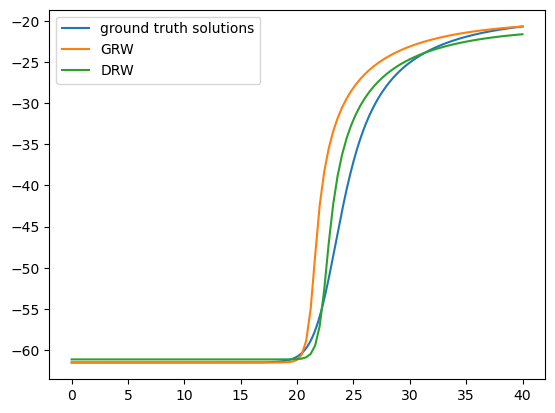

In [1]:
import math
import numpy as np
import torch
import time
import os
import matplotlib.pyplot as plt
from models import MLP1, MLP2, NN
from data_processing import load_data1, load_data2
from training import train_model
from correlations import theta, calculate_K, calculate_K_prime
from matrix import spetral_raduis, C, condition_number
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
np.seterr(divide='ignore', invalid='ignore')
def main():
    start_time = time.time()
    
    # Load data
    x, y = load_data1("reference_solutions_1-D_1.csv")
    v, w = load_data2("reference_solutions_1-D_2.csv")
    
    # Initialize models
    mlp1 = MLP1()
    mlp2 = MLP2()
    mlp3 = NN()

    # Define optimizers
    mlp_optimizer1 = torch.optim.SGD(mlp1.parameters(), lr=1e-3)
    mlp_optimizer2 = torch.optim.SGD(mlp2.parameters(), lr=1e-3)
    mlp_optimizer3 = torch.optim.SGD(mlp3.parameters(), lr=1e-2)
    
    # Train models
    epoch = 1000
    mlp_loss1 = train_model(mlp1, mlp_optimizer1, x, y, epoch)
    mlp_loss2 = train_model(mlp2, mlp_optimizer2, y, x, epoch)
    mlp_loss3 = train_model(mlp3, mlp_optimizer3, v, w, epoch)
    end_train=time.time()
    print("Training time:", end_train - start_time)
    
    # Define parameters
    Total_time=360
    K_s=9.44e-03
    theta_r=0.075
    theta_s=0.287
    alpha=1.611e06
    A=1.175e06
    beta=3.96
    gama=4.74
    maxr=0.8
    num_nodes=101
    initial_depth=0
    end_depth=40
    dz=(end_depth-initial_depth)/(num_nodes-1)
    iterations=10000
    tolerance=3.2e-5
    scale=1e10
    current_time=0 
    t_num=1
    boundary_residual_start=0
    boundary_residual_end=0 
    grid_z=np.arange(initial_depth,end_depth+dz,dz)
    
    # Define initial conditions
    psi_0=-6.15*np.ones(num_nodes)
    psi_0=torch.FloatTensor(psi_0)
    psi_0=psi_0.unsqueeze(1)
    
    ##########################################################################################
    # Map psi_0 to n_0 by neural networks
    ##########################################################################################
    
    n0=mlp2(psi_0);
    n0=n0.squeeze(1)
    n0=n0.detach().numpy()
    n0=scale*(10*n0)
    psi_0=psi_0*10
    psi_0=psi_0.squeeze(1)
    psi_0=psi_0.detach().numpy()
    soil_moisture_content= np.ones(num_nodes)
    n=n0;
    L=1*np.ones(num_nodes)
    L0=L
    init_num_particles=n[0]
    psi=psi_0
    n=n0
    
    # Calculate theta
    for num in range(0,num_nodes):
        soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)
    soil_moisture_content_0=soil_moisture_content
    psi_current=psi

   

    # Define and initialize necessary arrays   
    c=0
    flux_residual= np.zeros(num_nodes-2)
    K= np.ones(num_nodes-1)
    second_term= np.zeros(num_nodes-2)
    q= np.zeros(num_nodes-1)
    r=np.zeros(num_nodes-1)
    residual_coefficients= np.zeros(num_nodes)
    first_term= np.zeros(num_nodes)
    soil_moisture_content_diff=np.ones(num_nodes)
    g=np.zeros(num_nodes)
    h=np.zeros(num_nodes)

    # Simulation starts here:
    while current_time<=Total_time:
        for num in range(0,num_nodes-1):
            K[num]=calculate_K(psi[num],K_s,A,gama)
            #dt=1;
            dt=(np.power(dz,2)*maxr)/(2*max(K));
       
        
        tol_iterations=np.zeros(iterations);
        for iteration in range(0,iterations):
            OP=L
            for num in range(0,num_nodes-1):
                K[num]=calculate_K(psi[num],K_s,A,gama)
                dt=(np.power(dz,2)*maxr)/(2*max(K))
        ####################################################################################
        # Calculate the coefficients of the first term
        ####################################################################################
        
            for num in range(0,num_nodes-1):
                r[num]=dt*K[num]/((max(abs(L)))*math.pow(dz,2)) #random walk r
                residual_coefficients[0]=1-2*r[0]
            for num in range(1,num_nodes-1):
                residual_coefficients[num]=1-(r[num-1]+r[num])
                residual_coefficients[num_nodes-1]=1-2*r[num_nodes-2]
        
        ########################################################################################
        # Calculate the first term
        #########################################################################################
        
            for num in range(1,num_nodes):
                first_term[num]=residual_coefficients[num]*n[num]#+restr[num-1]
                first_term[0]=residual_coefficients[0]*n[0];
            first_term_adjustment=np.floor(first_term)
            new_number_of_particles=first_term_adjustment
            saturation_adjustment=n-new_number_of_particles
            boundary_residual_start=r[0]*n[0]
            saturation_adjustment_start=np.floor(boundary_residual_start)
            new_number_of_particles[1]=new_number_of_particles[1]+saturation_adjustment_start
        
        #########################################################################################
        # Calculate the second term
        #########################################################################################
        
            for num in range(0,num_nodes-2):
                second_term[num]=r[num]*n[num+1]
            second_term_adjustment=np.floor(second_term) 
            for num in range(0,num_nodes-2):
                new_number_of_particles[num] +=second_term_adjustment[num]
                new_number_of_particles[num+2]=new_number_of_particles[num+2]+saturation_adjustment[num+1]-second_term_adjustment[num];
            boundary_residual_end=r[num_nodes-2]*n[num_nodes-1]+boundary_residual_end 
            end_saturation_adjustment=np.floor(boundary_residual_end); 
            boundary_residual_end=boundary_residual_end-end_saturation_adjustment
            new_number_of_particles[num_nodes-2]=new_number_of_particles[num_nodes-2]+end_saturation_adjustment 
            new_number_of_particles[0]=init_num_particles
            new_number_of_particles[num_nodes-1]=-20.7*scale
            
        #############################################################################################   
        # Calculate the third term by neural network 
        #############################################################################################
        
            for num in range(0,num_nodes):
                soil_moisture_content_diff[num]=(soil_moisture_content[num]-soil_moisture_content_0[num])/max(abs(L))
            third_term_init=np.diff(r)*dz
            for num in range(0,num_nodes-2):
                third_term_init[num]=third_term_init[num]-soil_moisture_content_diff[num+1]
            
            third_term_init=torch.FloatTensor(third_term_init)
            third_term_init=third_term_init.unsqueeze(1)
            flux_residual=mlp3(third_term_init)
            flux_residual=flux_residual.squeeze(1)
            flux_residual=flux_residual.detach().numpy()
            third_term_init=third_term_init.squeeze(1)
            third_term_init=third_term_init.detach().numpy()
            third_term=np.floor(flux_residual)
            
        ########################################################################################    
        # Calculate RHS: n^(s+1) 
        ########################################################################################
        
            for num in range(1,num_nodes-1):
                new_number_of_particles[num]=new_number_of_particles[num]+third_term[num-1]
            n1=new_number_of_particles
            
        ######################################################################################
        # Map n^(s+1) to psi^(s+1) by neural network
        ######################################################################################
        
            n=n1*1e-11
            n=torch.FloatTensor(n)
            n=n.unsqueeze(1)
            psi=mlp1(n);
            psi=psi.squeeze(1)
            psi=psi.detach().numpy()
            psi=psi*10
            n=n*1e11
            n=n.squeeze(1)
            n=n.detach().numpy()
            tol_iteration=np.linalg.norm(psi-psi_current)/np.linalg.norm(psi)
            
        #######################################################################################    
        # Condition of adaptive L-scheme
        #######################################################################################
        
            if abs(calculate_K(psi_0[0],K_s,A,gama)*2/L[0]-1/(abs((1/(1e-2*psi[num_nodes-2]))*g[num_nodes-2]))*(calculate_K(psi[num_nodes-2],K_s,A,gama)+calculate_K(psi[num_nodes-3],K_s,A,gama)+h[num_nodes-2]))>1e-2*dt/dz**2 and iteration>1:
                current_iteration=iteration
                
                #break
                # Calculate the L
                if iteration>=current_iteration:
                    for num in range(1,num_nodes-1):
                        L[num]=max(L0[num],abs((1/(1e-4*psi[num]))*g[num]))
                        
                
            for num in range(1,num_nodes-1):
                g[num]=(-(r[num-1]+r[num])*n[num]+second_term_adjustment[num-1]+third_term[num-1])*OP[num]/scale/dt
                h[num]+=calculate_K_prime(psi[num], K_s, A, gama)*g[num]+calculate_K_prime(psi[num-1], K_s, A, gama)*g[num-1]
            
            if t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                tol_iterations[iteration]=tol_iteration
            if tol_iteration <= tolerance:
                break  
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)      
            psi_current=psi;
            if  t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                t_num+=1
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta) 
               
            for num in range(0,num_nodes-1):
                q[num]=-K[num]*((psi[num+1]-psi[num])/dz+1)
        c+=1
        current_time+=dt
    end_time = time.time()
    print("Total execution time:", end_time - start_time)
    
    ########################################################################
    # Construct the coefficient matrix A
    ########################################################################
    
    a_coeff,b_coeff=-residual_coefficients,r
    A=np.zeros((num_nodes,num_nodes))
    for i in range(1,num_nodes-1):
       A[i][i]=a_coeff[i]
       A[i][i+1]=-b_coeff[i]
       A[i+1][i]=-b_coeff[i-1]
    A[0][0]=a_coeff[0]
    A[0][1]=-b_coeff[0]
    A[1][0]=-b_coeff[0]
    A[num_nodes-1][num_nodes-1]=a_coeff[num_nodes-1]
    
    #######################################################################
    # Calculate the condition number
    #######################################################################
    
    spec=spetral_raduis(A)
    con=condition_number(A)
    print("Coefficient matrix:", A)
    print("Spetral raduis:", spec)
    print("Condition number:", con)
    ground_truth=np.loadtxt(open("ground_truth_solutions.csv"))
    GRW=np.loadtxt(open("GRW_solutions_s1.csv"))
    grid_gt= np.arange(0,40.1,0.1)
    plt.plot(grid_gt,ground_truth)
    plt.plot(grid_z,GRW)
    plt.plot(grid_z,psi)
    plt.legend(['ground truth solutions','GRW','DRW'], loc='upper left')
    plt.show
   
if __name__ == "__main__":
    main()

Training time: 62.26238703727722
Total execution time: 110.81005907058716
Coefficient matrix: [[-9.99958516e-01 -2.07418472e-05  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.07418472e-05 -9.99958516e-01 -2.07418472e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.07418472e-05 -9.99958516e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.96217577e-01
  -1.89911187e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.88331148e-03
  -9.96186849e-01 -1.91403924e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -1.89911187e-03 -9.96171922e-01]]
Spetral raduis: 0.9999999391180138
Condition number: 1.0073193382772268


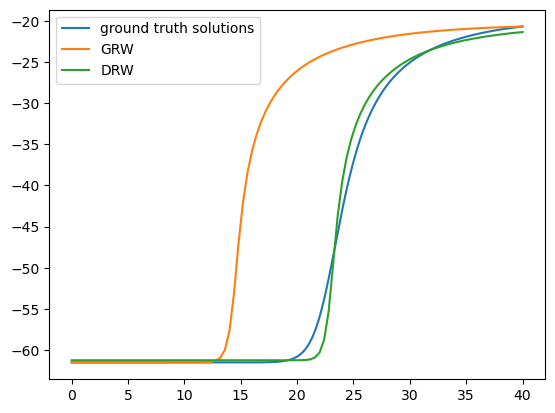

In [2]:
import math
import numpy as np
import torch
import time
import os
import matplotlib.pyplot as plt
from models import MLP1, MLP2, NN
from data_processing import load_data1, load_data2
from training import train_model
from correlations import theta, calculate_K, calculate_K_prime
from matrix import spetral_raduis, C, condition_number
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
np.seterr(divide='ignore', invalid='ignore')
def main():
    start_time = time.time()
    
    # Load data
    x, y = load_data1("reference_solutions_1-D_1.csv")
    v, w = load_data2("reference_solutions_1-D_2.csv")
    
    # Initialize models
    mlp1 = MLP1()
    mlp2 = MLP2()
    mlp3 = NN()

    # Define optimizers
    mlp_optimizer1 = torch.optim.SGD(mlp1.parameters(), lr=1e-3)
    mlp_optimizer2 = torch.optim.SGD(mlp2.parameters(), lr=1e-3)
    mlp_optimizer3 = torch.optim.SGD(mlp3.parameters(), lr=1e-2)
    
    # Train models
    epoch = 1000
    mlp_loss1 = train_model(mlp1, mlp_optimizer1, x, y, epoch)
    mlp_loss2 = train_model(mlp2, mlp_optimizer2, y, x, epoch)
    mlp_loss3 = train_model(mlp3, mlp_optimizer3, v, w, epoch)
    end_train=time.time()
    print("Training time:", end_train - start_time)
    
    # Define parameters
    Total_time=360
    K_s=9.44e-03
    theta_r=0.075
    theta_s=0.287
    alpha=1.611e06
    A=1.175e06
    beta=3.96
    gama=4.74
    maxr=0.8
    num_nodes=101
    initial_depth=0
    end_depth=40
    dz=(end_depth-initial_depth)/(num_nodes-1)
    iterations=500
    tolerance=1e-10
    scale=1e10
    current_time=0 
    t_num=1
    boundary_residual_start=0
    boundary_residual_end=0 
    grid_z=np.arange(initial_depth,end_depth+dz,dz)
    
    # Define initial conditions
    psi_0=-6.15*np.ones(num_nodes)
    psi_0=torch.FloatTensor(psi_0)
    psi_0=psi_0.unsqueeze(1)
    
    ##########################################################################################
    # Map psi_0 to n_0 by neural networks
    ##########################################################################################
    
    n0=mlp2(psi_0);
    n0=n0.squeeze(1)
    n0=n0.detach().numpy()
    n0=scale*(10*n0)
    psi_0=psi_0*10
    psi_0=psi_0.squeeze(1)
    psi_0=psi_0.detach().numpy()
    soil_moisture_content= np.ones(num_nodes)
    n=n0;
    L=1*np.ones(num_nodes)
    L0=L
    init_num_particles=n[0]
    psi=psi_0
    n=n0
    
    # Calculate theta
    for num in range(0,num_nodes):
        soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)
    soil_moisture_content_0=soil_moisture_content
    psi_current=psi

   

    # Define and initialize necessary arrays   
    c=0
    flux_residual= np.zeros(num_nodes-2)
    K= np.ones(num_nodes-1)
    second_term= np.zeros(num_nodes-2)
    q= np.zeros(num_nodes-1)
    r=np.zeros(num_nodes-1)
    residual_coefficients= np.zeros(num_nodes)
    first_term= np.zeros(num_nodes)
    soil_moisture_content_diff=np.ones(num_nodes)
    g=np.zeros(num_nodes)
    h=np.zeros(num_nodes)

    # Simulation starts here:
    while current_time<=Total_time:
        for num in range(0,num_nodes-1):
            K[num]=calculate_K(psi[num],K_s,A,gama)
            #dt=1;
            dt=(np.power(dz,2)*maxr)/(2*max(K));
       
        
        tol_iterations=np.zeros(iterations);
        for iteration in range(0,iterations):
            OP=L
            for num in range(0,num_nodes-1):
                K[num]=calculate_K(psi[num],K_s,A,gama)
                dt=(np.power(dz,2)*maxr)/(2*max(K))
        ####################################################################################
        # Calculate the coefficients of the first term
        ####################################################################################
        
            for num in range(0,num_nodes-1):
                r[num]=dt*K[num]/((max(abs(L)))*math.pow(dz,2)) #random walk r
                residual_coefficients[0]=1-2*r[0]
            for num in range(1,num_nodes-1):
                residual_coefficients[num]=1-(r[num-1]+r[num])
                residual_coefficients[num_nodes-1]=1-2*r[num_nodes-2]
        
        ########################################################################################
        # Calculate the first term
        #########################################################################################
        
            for num in range(1,num_nodes):
                first_term[num]=residual_coefficients[num]*n[num]#+restr[num-1]
                first_term[0]=residual_coefficients[0]*n[0];
            first_term_adjustment=np.floor(first_term)
            new_number_of_particles=first_term_adjustment
            saturation_adjustment=n-new_number_of_particles
            boundary_residual_start=r[0]*n[0]
            saturation_adjustment_start=np.floor(boundary_residual_start)
            new_number_of_particles[1]=new_number_of_particles[1]+saturation_adjustment_start
        
        #########################################################################################
        # Calculate the second term
        #########################################################################################
        
            for num in range(0,num_nodes-2):
                second_term[num]=r[num]*n[num+1]
            second_term_adjustment=np.floor(second_term) 
            for num in range(0,num_nodes-2):
                new_number_of_particles[num] +=second_term_adjustment[num]
                new_number_of_particles[num+2]=new_number_of_particles[num+2]+saturation_adjustment[num+1]-second_term_adjustment[num];
            boundary_residual_end=r[num_nodes-2]*n[num_nodes-1]+boundary_residual_end 
            end_saturation_adjustment=np.floor(boundary_residual_end); 
            boundary_residual_end=boundary_residual_end-end_saturation_adjustment
            new_number_of_particles[num_nodes-2]=new_number_of_particles[num_nodes-2]+end_saturation_adjustment 
            new_number_of_particles[0]=init_num_particles
            new_number_of_particles[num_nodes-1]=-20.7*scale
            
        #############################################################################################   
        # Calculate the third term by neural network 
        #############################################################################################
        
            for num in range(0,num_nodes):
                soil_moisture_content_diff[num]=(soil_moisture_content[num]-soil_moisture_content_0[num])/max(abs(L))
            third_term_init=np.diff(r)*dz
            for num in range(0,num_nodes-2):
                third_term_init[num]=third_term_init[num]-soil_moisture_content_diff[num+1]
            
            third_term_init=torch.FloatTensor(third_term_init)
            third_term_init=third_term_init.unsqueeze(1)
            flux_residual=mlp3(third_term_init)
            flux_residual=flux_residual.squeeze(1)
            flux_residual=flux_residual.detach().numpy()
            third_term_init=third_term_init.squeeze(1)
            third_term_init=third_term_init.detach().numpy()
            third_term=np.floor(flux_residual)
            
        ########################################################################################    
        # Calculate RHS: n^(s+1) 
        ########################################################################################
        
            for num in range(1,num_nodes-1):
                new_number_of_particles[num]=new_number_of_particles[num]+third_term[num-1]
            n1=new_number_of_particles
            
        ######################################################################################
        # Map n^(s+1) to psi^(s+1) by neural network
        ######################################################################################
        
            n=n1*1e-11
            n=torch.FloatTensor(n)
            n=n.unsqueeze(1)
            psi=mlp1(n);
            psi=psi.squeeze(1)
            psi=psi.detach().numpy()
            psi=psi*10
            n=n*1e11
            n=n.squeeze(1)
            n=n.detach().numpy()
            tol_iteration=np.linalg.norm(psi-psi_current)/np.linalg.norm(psi)
            
        #######################################################################################    
        # Condition of adaptive L-scheme
        #######################################################################################
        
            if abs(calculate_K(psi_0[0],K_s,A,gama)*2/L[0]-1/(abs((1/(1e-2*psi[num_nodes-2]))*g[num_nodes-2]))*(calculate_K(psi[num_nodes-2],K_s,A,gama)+calculate_K(psi[num_nodes-3],K_s,A,gama)+h[num_nodes-2]))>1e-2*dt/dz**2 and iteration>1:
                current_iteration=iteration
                
                #break
                # Calculate the L
                if iteration>=current_iteration:
                    for num in range(1,num_nodes-1):
                        L[num]=max(L0[num],abs((1/(1e-4*psi[num]))*g[num]))
                        
                
            for num in range(1,num_nodes-1):
                g[num]=(-(r[num-1]+r[num])*n[num]+second_term_adjustment[num-1]+third_term[num-1])*OP[num]/scale/dt
                h[num]+=calculate_K_prime(psi[num], K_s, A, gama)*g[num]+calculate_K_prime(psi[num-1], K_s, A, gama)*g[num-1]
            
            if t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                tol_iterations[iteration]=tol_iteration
            if tol_iteration <= tolerance:
                break  
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta)      
            psi_current=psi;
            if  t_num*0.2*Total_time>=current_time and t_num*0.2*Total_time<current_time+dt: 
                t_num+=1
            for num in range(0,num_nodes):
                soil_moisture_content[num]=theta(psi[num],K_s,theta_r,theta_s,alpha,beta) 
               
            for num in range(0,num_nodes-1):
                q[num]=-K[num]*((psi[num+1]-psi[num])/dz+1)
        c+=1
        current_time+=dt
    end_time = time.time()
    print("Total execution time:", end_time - start_time)
    
    ########################################################################
    # Construct the coefficient matrix A
    ########################################################################
    
    a_coeff,b_coeff=-residual_coefficients,r
    A=np.zeros((num_nodes,num_nodes))
    for i in range(1,num_nodes-1):
       A[i][i]=a_coeff[i]
       A[i][i+1]=-b_coeff[i]
       A[i+1][i]=-b_coeff[i-1]
    A[0][0]=a_coeff[0]
    A[0][1]=-b_coeff[0]
    A[1][0]=-b_coeff[0]
    A[num_nodes-1][num_nodes-1]=a_coeff[num_nodes-1]
    
    #######################################################################
    # Calculate the condition number
    #######################################################################
    
    spec=spetral_raduis(A)
    con=condition_number(A)
    print("Coefficient matrix:", A)
    print("Spetral raduis:", spec)
    print("Condition number:", con)
    ground_truth=np.loadtxt(open("ground_truth_solutions.csv"))
    GRW=np.loadtxt(open("GRW_solutions.csv"))
    grid_gt= np.arange(0,40.1,0.1)
    plt.plot(grid_gt,ground_truth)
    plt.plot(grid_z,GRW)
    plt.plot(grid_z,psi)
    plt.legend(['ground truth solutions','GRW','DRW'], loc='upper left')
    plt.show
   
if __name__ == "__main__":
    main()